# SIR model

----


In [26]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as md

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    
    return dSdt, dIdt, dRdt
    

def sir_results(df_city, scenario, dias_doente, perc_infectados_internacao, study):
    """
    Modelo de simulação de evolução do COVID-19 no município em diferentes cenários dado .
    
    Parameters
    ----------
    
    df_city : pandas. dataframe
        Dataframe dos casos do município na última data
        
    scenario : string
        Cenário escolhido (nothing, isolamento, lockdown) - ver dicionário parameters_statics
        
    perc_leitos_ocupados : float
        
        
    """
    
    # Total population
    N = df_city['populacao'].values[0]

    # Contact rate (R0)
    R0 = parameters_statics[study][scenario]['R_0']
    
    # Initial conditions
    y0 = list()
    
    # => Number of infected
    I_i0 = df_city['confirmed'].values[0]
    # y0.append(I_i0)
    
    # => Recovered individuals
    R_i0 = 0 # parameter!
    # y0.append(R_i0)
    
    # => Susceptible individuals (assuming once recovered, you don't get infected again)
    S_i0 = N - I_i0 - R_i0
    # y0.append(S_i0)
    
    # Mean recovery rate (in 1/days)
    gamma = 1. / dias_doente
    beta = R0 * gamma

    # A grid of time points (in days)
    days = 365
    t = np.linspace(0, days, days)
    
    # Integrate the SIR equations over the time grid, t.
    y0 = (S_i0, I_i0, R_i0)
    ret = odeint(deriv, y0=y0, t=t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    # UTI demand
    uti_demand = I * perc_infectados_internacao / 100
    
    
    # Create output dataframe
    dd = pd.DataFrame([municipio]*days,columns=['municipio'])
    
    dd['uf']=df_city['uf'].values[0]
    dd['place_type'] = df_city['place_type'].values[0]
    dd['populacao'] = N
    dd['dias_doente'] = dias_doente
    dd['percentual_infectados_que_precisam_de_internacao'] = perc_infectados_internacao
    dd['data_numero_infectados'] = df_city['date'].values[0]
    dd['numero_infectados'] = I_i0
    
    n_beds = df_city['quantidade_leitos'].values[0]
    dd['leitos_total'] = n_beds
    
    dd['dias'] = t
    dd['demanda_por_uti'] = uti_demand
    dd['cenario'] = scenario
    dd['suscetiveis'] = S
    dd['infectados'] = I
    dd['recuperados'] = R
    
    # ====> PENSAR PARA SEPARAR ESSA PARTE!
    # Iterate model over % of beds used
    list_perc_leitos_ocupados = [50,60,70,80,90]
    
    dd_final = pd.DataFrame()
    for perc_leitos in list_perc_leitos_ocupados:
        
        df_perc = dd.copy()
        df_perc['in_percentual_leitos_ocupados'] = perc_leitos

        # Beds available
        n_beds_in_use = n_beds * perc_leitos / 100
        n_beds_available = n_beds - n_beds_in_use

        # Compare to capacity
        if max(uti_demand) > n_beds_available:
            dday = uti_demand[uti_demand > n_beds_available][0]
            dday = np.where(uti_demand == dday)[0][0]

        else:
            dday = -1

        df_perc['leitos_ocupados_outras_doencas'.format(perc_leitos)] = n_beds_in_use
        df_perc['leitos_disponiveis'.format(perc_leitos)] = n_beds_available
        df_perc['dias_para_colapso'.format(perc_leitos)] = dday  

        dd_final = pd.concat([dd_final, df_perc],axis=0)

    return(dd_final)
    
#     for perc_leitos in list_perc_leitos_ocupados:
        
#         # Beds available
#         n_beds_in_use = df_city['quantidade_leitos'].values[0] * perc_leitos / 100
#         n_beds_available = n_beds - n_beds_in_use
        
#         # Compare to capacity
#         if max(uti_demand) > n_beds_available == True:
#             dday = uti_demand[uti_demand > leitos][0]
#             dday = np.where(uti_demand == dday)[0][0]

#         else:
#             dday = -1
            
#         dd['{}_leitos_ocupados_outras_doencas'.format(perc_leitos)] = n_beds_in_use
#         dd['{}_porcentagem_leitos_ocupados'.format(perc_leitos)] = perc_leitos
#         dd['{}_leitos_disponiveis'.format(perc_leitos)] = n_beds_available
#         dd['{}_dias_para_colapso'.format(perc_leitos)] = dday
        
#     return(dd)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Collect-cases-script" data-toc-modified-id="Collect-cases-script-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span>Collect cases script</a></span></li><li><span><a href="#Check-treatment" data-toc-modified-id="Check-treatment-0.0.2"><span class="toc-item-num">0.0.2&nbsp;&nbsp;</span>Check treatment</a></span></li></ul></li><li><span><a href="#import-data" data-toc-modified-id="import-data-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>import data</a></span></li><li><span><a href="#Testing-new-cases-dataset:-https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv" data-toc-modified-id="Testing-new-cases-dataset:-https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Testing new cases dataset: <a href="https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv" target="_blank">https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv</a></a></span></li><li><span><a href="#define-parametes" data-toc-modified-id="define-parametes-0.3"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>define parametes</a></span></li><li><span><a href="#run-model-function" data-toc-modified-id="run-model-function-0.4"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>run model function</a></span></li><li><span><a href="#plot-city" data-toc-modified-id="plot-city-0.5"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>plot city</a></span></li></ul></li><li><span><a href="#MODELO" data-toc-modified-id="MODELO-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>MODELO</a></span></li></ul></div>

#### Collect cases script

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# import paths
# from scripts import get_raw
# df = get_raw.covid_cases()

#### Check treatment

In [4]:
# from scripts import clean_databases
# dfs = clean_databases.treat_all()
# len(dfs)

In [5]:
import pandas as pd
from paths import *
import numpy as np
import plotly.express as px


sorted(TREAT_PATH.glob('*.csv'))

[PosixPath('/Users/fernandascovino/Projects/SimulaCorona/data/treated/treated_covid19_SUS_database.csv'),
 PosixPath('/Users/fernandascovino/Projects/SimulaCorona/data/treated/treated_covid19_cases.csv')]

### import data

In [6]:
# import sus data
df_sus = pd.read_csv(TREAT_PATH / 'treated_covid19_SUS_database.csv')
cols = ['municipio_uf', 'municipio','uf','populacao' ,'quantidade_leitos']
df_sus = df_sus[cols].fillna(0)

# remove apostoflo
df_sus['municipio'] = df_sus['municipio'].str.replace('\'', '')
df_sus['municipio_uf'] = df_sus['municipio_uf'].str.replace('\'', '')

# get the information for states
df_states = df_sus.groupby(by='uf', as_index=False).sum()
df_states['municipio'] = df_states['uf']
df_states['municipio_uf'] = df_states['uf']

# # put states in same order as df_sus
cols = df_sus.columns
df_states = df_states[cols]

# concat states information with sus information
df_sus = pd.concat([df_states,df_sus],axis=0)

In [7]:
df_sus.info() # cities + states

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5597 entries, 0 to 5569
Data columns (total 5 columns):
municipio_uf         5597 non-null object
municipio            5597 non-null object
uf                   5597 non-null object
populacao            5597 non-null int64
quantidade_leitos    5597 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 262.4+ KB


### Testing new cases dataset: https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time.csv

In [8]:
df_cases2 = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-cities-time.csv')
df_cases2 = df_cases2.sort_values(by='date', ascending=False)

In [9]:
from unidecode import unidecode
df_cases2 = df_cases2.rename({'totalCases': 'confirmed', 'newCases': 'new_confirmed'}, axis=1)
df_cases2 = df_cases2[df_cases2['state'] != 'TOTAL']

df_cases2['municipio_uf'] = df_cases2['city'].str.replace('/', ' ').str.upper().apply(lambda x : unidecode(x))
df_cases2['place_type'] = 'city'

df_cases2.head()

,date,country,state,city,new_confirmed,confirmed,municipio_uf,place_type
506,2020-03-20,Brazil,SC,Chapecó/SC,1,1,CHAPECO SC,city
492,2020-03-20,Brazil,RS,Torres/RS,1,2,TORRES RS,city
493,2020-03-20,Brazil,BA,Lauro de Freitas/BA,1,3,LAURO DE FREITAS BA,city
494,2020-03-20,Brazil,RS,Alvorada/RS,1,2,ALVORADA RS,city
495,2020-03-20,Brazil,RS,Erechim/RS,1,3,ERECHIM RS,city


In [10]:
# get only last day data for each city
df_cases2 = df_cases2.drop_duplicates(subset=['city'], keep='first')
df_cases2 = df_cases2.sort_values(by='confirmed', ascending=False)

cols = ['municipio_uf', 'city', 'place_type','date','confirmed']
df_cases2 = df_cases2[cols]

# merge sus and cases data
df = pd.merge(df_cases2, df_sus, how='left', on='municipio_uf')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 0 to 121
Data columns (total 9 columns):
municipio_uf         122 non-null object
city                 122 non-null object
place_type           122 non-null object
date                 122 non-null object
confirmed            122 non-null int64
municipio            122 non-null object
uf                   122 non-null object
populacao            122 non-null int64
quantidade_leitos    122 non-null float64
dtypes: float64(1), int64(2), object(6)
memory usage: 9.5+ KB


In [12]:
# # import cases data
# df_cases = pd.read_csv(TREAT_PATH / 'treated_covid19_cases.csv', index_col=0).sort_values(by='date', ascending=False)
# # df_cases['municipio'] = df_cases['municipio']

# mask = df_cases['place_type']=='state'
# df_cases['municipio'] = np.where(mask, df_cases['uf'],df_cases['municipio'])

# # get only last day data for each city
# df_cases = df_cases.drop_duplicates(subset=['municipio'], keep='first')
# df_cases = df_cases.sort_values(by='confirmed', ascending=False)

# cols = ['municipio_uf', 'municipio','place_type','date','confirmed','deaths','discarded','suspect']
# df_cases = df_cases[cols]

# # merge sus and cases data
# df = pd.merge(df_cases, df_sus, how='left', on='municipio_uf' )

### define parametes

In [13]:
parameters_statics = {
    'imp_college': {
                      'nothing'   : {'R_0': 2.4}, # {'R_0':3.88},
                      'isolamento': {'R_0': 2.2}, # {'R_0':1.26},
                      'lockdown'  : {'R_0': 2} # {'R_0':0.32}
                     },
    'wuhan': {
                  'nothing'   : {'R_0':3.88},
                  'isolamento': {'R_0':1.26},
                  'lockdown'  : {'R_0':0.32}
                 }
}

# perc_leitos_ocupados = 78
dias_doente = 15
perc_infectados_internacao = 8

### run model function

In [27]:
df_final = pd.DataFrame()

for study in parameters_statics.keys():
    dic_study = parameters_statics[study]
    
    for municipio in df['municipio'].unique():
        for scenario in dic_study.keys():

            mask = df['municipio'] == municipio
            df_city = df[mask]
            
            dd = sir_results(df_city, scenario, dias_doente, perc_infectados_internacao, study)
            df_final = pd.concat([df_final,dd],axis=0)

    df_final.to_csv(OUTPUT_PATH / 'model_for_city_{}.csv'.format(study), index=False)
        
# df_final.to_csv('../data/output/model_for_city.csv', index=False)

KeyboardInterrupt: 

In [ ]:
len(df_final)

In [ ]:
# municipio = 'São Paulo'
# df_final = pd.DataFrame()

# study = 'imp_college'

# for scenario in parameters_statics[study].keys():
        
#     mask = df['municipio'] == municipio
#     df_city = df[mask]
    
#     dd = sir_results(df_city, scenario, dias_doente, perc_infectados_internacao, study)
#     df_final = pd.concat([df_final,dd],axis=0)

### plot city

In [ ]:
municipio = 'São Paulo'
mask = df_final['municipio']== municipio
dd = df_final[mask]

dd.head()

In [99]:
perc = 80

fig = px.line(dd[dd['in_percentual_leitos_ocupados'] == perc], x='dias',y='demanda_por_uti', color='cenario')
fig

,municipio,uf,place_type,populacao,dias_doente,percentual_infectados_que_precisam_de_internacao,data_numero_infectados,numero_infectados,leitos_total,dias,demanda_por_uti,cenario,suscetiveis,infectados,recuperados,in_percentual_leitos_ocupados,leitos_ocupados_outras_doencas,leitos_disponiveis,dias_para_colapso
0,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,0.000000,29.280000,nothing,1.225166e+07,366.000000,0.000000e+00,80,22277.6,5569.4,57
1,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,1.002747,32.152469,nothing,1.225160e+07,401.905862,2.564847e+01,80,22277.6,5569.4,57
2,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,2.005495,35.306707,nothing,1.225153e+07,441.333841,5.381313e+01,80,22277.6,5569.4,57
3,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,3.008242,38.770348,nothing,1.225145e+07,484.629353,8.474080e+01,80,22277.6,5569.4,57
4,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,4.010989,42.573734,nothing,1.225137e+07,532.171681,1.187025e+02,80,22277.6,5569.4,57
5,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,5.013736,46.750182,nothing,1.225128e+07,584.377280,1.559958e+02,80,22277.6,5569.4,57
6,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,6.016484,51.336272,nothing,1.225118e+07,641.703404,1.969476e+02,80,22277.6,5569.4,57
7,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,7.019231,56.372172,nothing,1.225108e+07,704.652150,2.419166e+02,80,22277.6,5569.4,57
8,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,8.021978,61.901983,nothing,1.225096e+07,773.774790,2.912969e+02,80,22277.6,5569.4,57
9,São Paulo,SP,city,12252023,15,8,2020-03-20,366,27847.0,9.024725,67.974129,nothing,1.225083e+07,849.676611,3.455210e+02,80,22277.6,5569.4,57


## MODELO

- SIR - https://scipython.com/book/chapter-8-scipy/additional-examples/the-sir-epidemic-model/
- https://colab.research.google.com/drive/1bmR-W2NvQ7gPnldTfei927NtGJUCC1BB#scrollTo=47Er1T5YZBXf

    ro - fixo para cada cidade
    populacao de cada cidade


In [82]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.dates as md

#@title Variables { run: "auto" }
population_in_million = 220 #@param {type:"number"}
percentage_of_immunity =  1#@param {type:"integer"}
number_of_infected =  125#@param {type:"integer"}
number_of_infected_per_person_R0 =  2.5#@param {type:"number"}
days_to_get_better = 15 #@param {type:"number"}
hospital_capacity_in_thousands = 300#@param {type:"number"}
percentage_of_infected_that_needs_hospital = 5#@param {type:"number"}


In [83]:
# Variables

# Total population, N.
N = population_in_million * 1e6

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = number_of_infected, number_of_infected * percentage_of_immunity

# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
R_0 = number_of_infected_per_person_R0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

gamma = 1. / days_to_get_better
beta = R_0 * gamma

hospital_capacity = hospital_capacity_in_thousands * 1e3

# A grid of time points (in days)
days = 360
t = np.linspace(0, days, days)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = ret.T

uti_demand = I * percentage_of_infected_that_needs_hospital / 100  / 1e3

dday = uti_demand[uti_demand > hospital_capacity_in_thousands][0]
dday = np.where(uti_demand == dday)[0][0]



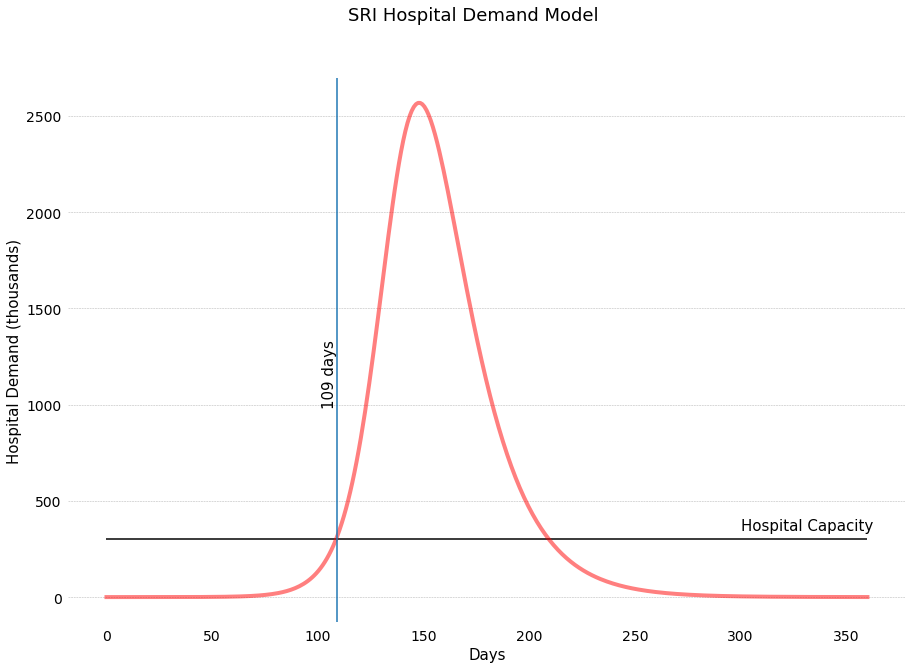

In [84]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
lw = 4
fig = plt.figure(facecolor='w', figsize=(15, 10))
ax = fig.add_subplot(111, axisbelow=True)

ax.plot(t, uti_demand,
            'r', alpha=0.5, lw=lw)

ax.hlines(hospital_capacity_in_thousands, 0, days)
ax.text(300, hospital_capacity_in_thousands + 50, 
        f'Hospital Capacity', rotation=0, fontdict={"size":15})
ax.axvline(dday)
ax.text(dday-7, 1e3 , f'{dday} days', rotation=90, fontdict={"size":15})


ax.tick_params(axis='both', which='both', labelsize=14,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)

ax.set_xlabel('Days', fontdict={"size":15})
ax.set_ylabel('Hospital Demand (thousands)', fontdict={"size":15})

ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.suptitle('SRI Hospital Demand Model', fontsize=18, ha='center')

for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()